In [ ]:
#Mounting to the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Required installations
!pip install klib
!pip install flask flask-ngrok


In [ ]:
#Required imports for the task
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import klib
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder,OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib
from joblib import dump,load

import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path='/content/drive/My Drive/Sunbase/customer_churn_large_dataset.xlsx'

In [ ]:
# load the dataset
df=pd.read_excel(file_path)



**Step1 : Data Understanding**

######**Explore the data/Analysis**
######We will analyse the following:

```

The target variable

Variable types (categorical and numerical)

Numerical variables
    Discrete
    Continuous
    Distributions
    Transformations

Categorical variables
    Cardinality
    Rare Labels
    Special mappings

Null Data

Text data

wich columns will we use

IS there outliers that can destory our algo

IS there diffrent range of data

Curse of dimm...
```


In [ ]:
# First five records of the dataset
df.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [ ]:
#Last five records of the dataset
df.tail()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
99995,99996,Customer_99996,33,Male,Houston,23,55.13,226,1
99996,99997,Customer_99997,62,Female,New York,19,61.65,351,0
99997,99998,Customer_99998,64,Male,Chicago,17,96.11,251,1
99998,99999,Customer_99999,51,Female,New York,20,49.25,434,1
99999,100000,Customer_100000,27,Female,Los Angeles,19,76.57,173,1


In [ ]:
# Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  int64  
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  int64  
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB


###**Reduce Memory**

In [ ]:
# function to optimize the dataset size
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        name =df[col].dtype.name

        if col_type != object and col_type.name != 'category':
        #if name != "category":
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
reduce_mem_usage(df)

Memory usage of dataframe is 6.87 MB
Memory usage after optimization is: 4.40 MB
Decreased by 35.9%


,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.37500,236,0
1,2,Customer_2,62,Female,New York,1,48.75000,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.50000,460,0
3,4,Customer_4,36,Female,Miami,3,97.93750,297,1
4,5,Customer_5,46,Female,Miami,19,58.12500,266,0
...,...,...,...,...,...,...,...,...,...
99995,99996,Customer_99996,33,Male,Houston,23,55.12500,226,1
99996,99997,Customer_99997,62,Female,New York,19,61.65625,351,0
99997,99998,Customer_99998,64,Male,Chicago,17,96.12500,251,1
99998,99999,Customer_99999,51,Female,New York,20,49.25000,434,1


In [ ]:
#Information after optimization
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   CustomerID                  100000 non-null  int32   
 1   Name                        100000 non-null  category
 2   Age                         100000 non-null  int8    
 3   Gender                      100000 non-null  category
 4   Location                    100000 non-null  category
 5   Subscription_Length_Months  100000 non-null  int8    
 6   Monthly_Bill                100000 non-null  float16 
 7   Total_Usage_GB              100000 non-null  int16   
 8   Churn                       100000 non-null  int8    
dtypes: category(3), float16(1), int16(1), int32(1), int8(3)
memory usage: 4.4 MB


In [ ]:
#All Columns in the data set
df.columns

Index(['CustomerID', 'Name', 'Age', 'Gender', 'Location',
       'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB',
       'Churn'],
      dtype='object')

###**Missing Values**


In [ ]:
# summarize the number of rows with missing values for each column
for i in range(df.shape[1]):
    # count number of rows with missing values
    n_miss = df.iloc[:,i].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 0 (0.0%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 0 (0.0%)
> 4, Missing: 0 (0.0%)
> 5, Missing: 0 (0.0%)
> 6, Missing: 0 (0.0%)
> 7, Missing: 0 (0.0%)
> 8, Missing: 0 (0.0%)


In [ ]:
klib.missingval_plot(df)

No missing values found in the dataset.


###**Duplicates Data**

In [ ]:
print("Total number of duplicate records:",df.duplicated().sum())

Total number of duplicate records: 0


####**Outlier Identification**


**Skewness** :

Skewness is computed for each row or each column of the data present in the DataFrame object.

Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

**Important Notes:**

· If the skewness is between -0.5 and 0.5, the data are fairly symmetrical

· If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed

· If the skewness is less than -1 or greater than 1, the data are highly skewed


In [ ]:
# Convert the data type to float64 for the Monthly_Bill column
df['Monthly_Bill'] = df['Monthly_Bill'].astype('float64')

# Calculate skewness
skew = df.skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'skew': skew})
print(skew_df.head(10))


                                skew
Churn                       0.008840
Total_Usage_GB              0.007113
CustomerID                  0.000000
Monthly_Bill               -0.000329
Subscription_Length_Months -0.001655
Age                        -0.002689


In [ ]:
skew_df[(skew_df['skew']>=1) |(skew_df['skew']<=-1) ].index

Index([], dtype='object')

Our data is not skewed.

**Kurtosis**

**Describe:**

· Kurtosis is one of the two measures that quantify shape of a distribution. kutosis determine the volume of the outlier

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers.

· Kurtosis describes the peakedness of the distribution.

· If the distribution is tall and thin it is called a leptokurtic distribution(Kurtosis > 3). Values in a leptokurtic distribution are near the mean or at the extremes.

· A flat distribution where the values are moderately spread out (i.e., unlike leptokurtic) is called platykurtic(Kurtosis <3) distribution.

· A distribution whose shape is in between a leptokurtic distribution and a platykurtic distribution is called a mesokurtic(Kurtosis=3) distribution. A mesokurtic distribution looks more close to a normal distribution.

· Kurtosis is sometimes reported as “excess kurtosis.” Excess kurtosis is determined by subtracting 3 from the kurtosis. This makes the normal distribution kurtosis equal 0.

**Important Notes:**

· Along with skewness, kurtosis is an important descriptive statistic of data distribution. However, the two concepts must not be confused with each other. Skewness essentially measures the symmetry of the distribution, while kurtosis determines the heaviness of the distribution tails.

· It is the sharpness of the peak of a frequency-distribution curve .It is actually the measure of outliers present in the distribution.

· High kurtosis in a data set is an indicator that data has heavy outliers.

· Low kurtosis in a data set is an indicator that data has lack of outliers.
```
The kurtosis of a normal distribution is 3.
If a given distribution has a kurtosis less than 3, it is said to be playkurtic, which means it tends to produce fewer and less extreme outliers than the normal distribution.
If a given distribution has a kurtosis greater than 3, it is said to be leptokurtic, which means it tends to produce more outliers than the normal distribution.
```

In [ ]:
# Calculate Kurtosis
kurtosis= pd.DataFrame(df.kurtosis(),columns=['Kurtosis'])
print(kurtosis.head(8))

                            Kurtosis
CustomerID                 -1.200000
Age                        -1.198180
Subscription_Length_Months -1.205610
Monthly_Bill               -1.204570
Total_Usage_GB             -1.201278
Churn                      -1.999962


In [ ]:
kurtosis[(kurtosis['Kurtosis']>=3) |(kurtosis['Kurtosis']<=-3) ].index

Index([], dtype='object')

**Variance :**

Features with low variance should be eliminated

In [ ]:
#Calculate Variance
var= df.var().sort_values(ascending =True )
var_df= pd.DataFrame({'var':var})
print(var_df.head(10))

                                     var
Churn                       2.499976e-01
Subscription_Length_Months  4.797586e+01
Age                         2.334870e+02
Monthly_Bill                4.092797e+02
Total_Usage_GB              1.702061e+04
CustomerID                  8.333417e+08


###**Quantile Data:**

In [ ]:
# Calcualte IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

CustomerID                    49999.50000
Age                              26.00000
Subscription_Length_Months       13.00000
Monthly_Bill                     35.09375
Total_Usage_GB                  226.00000
Churn                             1.00000
dtype: float64


In [ ]:
# Outlier detection and removal
df_num=df.select_dtypes(exclude=['category'])
df_out = df_num[~((df_num < (Q1 - 1.5 * IQR))|(df_num > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df_out.shape)
del df_num
del df_out

(100000, 6)


Identifying outliers in data is an important part of statistical analyses. One simple rule of thumb (due to John Tukey) for finding outliers is based on the quartiles of the data: the first quartile  **Q1**
  is the value  **≥1/4**
  of the data, the second quartile  **Q2**
  or the median is the value  **≥1/2**
  of the data, and the third quartile  **Q3**
  is the value  **≥3/4**
  of the data. The interquartile range,  **IQR**
 , is **Q3-Q1**
 .

Tukey's rule says that the outliers are values more than  1.5
  times the interquartile range from the quartiles --- either below  **Q1−1.5IQR**
 , or above  **Q3+1.5IQR**
 .

**(100000, 6)** this is the shape of data keeped after eliminating outliers

###**Stat Analysis: shape , mean,median...**

In [ ]:
#Dimensions of the dataset
df.shape

(100000, 9)

In [ ]:
# Descriptive stat values of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,100000.0,50000.500000,28867.657797,1.0,25000.75000,50000.5,75000.250,100000.0
Age,100000.0,44.027020,15.280283,18.0,31.00000,44.0,57.000,70.0
Subscription_Length_Months,100000.0,12.490100,6.926461,1.0,6.00000,12.0,19.000,24.0
Monthly_Bill,100000.0,65.053228,20.230662,30.0,47.53125,65.0,82.625,100.0
Total_Usage_GB,100000.0,274.393650,130.463063,50.0,161.00000,274.0,387.000,500.0
Churn,100000.0,0.497790,0.499998,0.0,0.00000,0.0,1.000,1.0


In [ ]:
# Split dependent and independent variables
target= "Churn"
X = df.drop(target, axis='columns')# axis=1
y = df[target].to_numpy()

In [ ]:
# Feature classification
cat_columns = X.select_dtypes(exclude=[np.number]).columns
num_columns = X.select_dtypes(include=[np.number]).columns

###**Visual Exploratory**

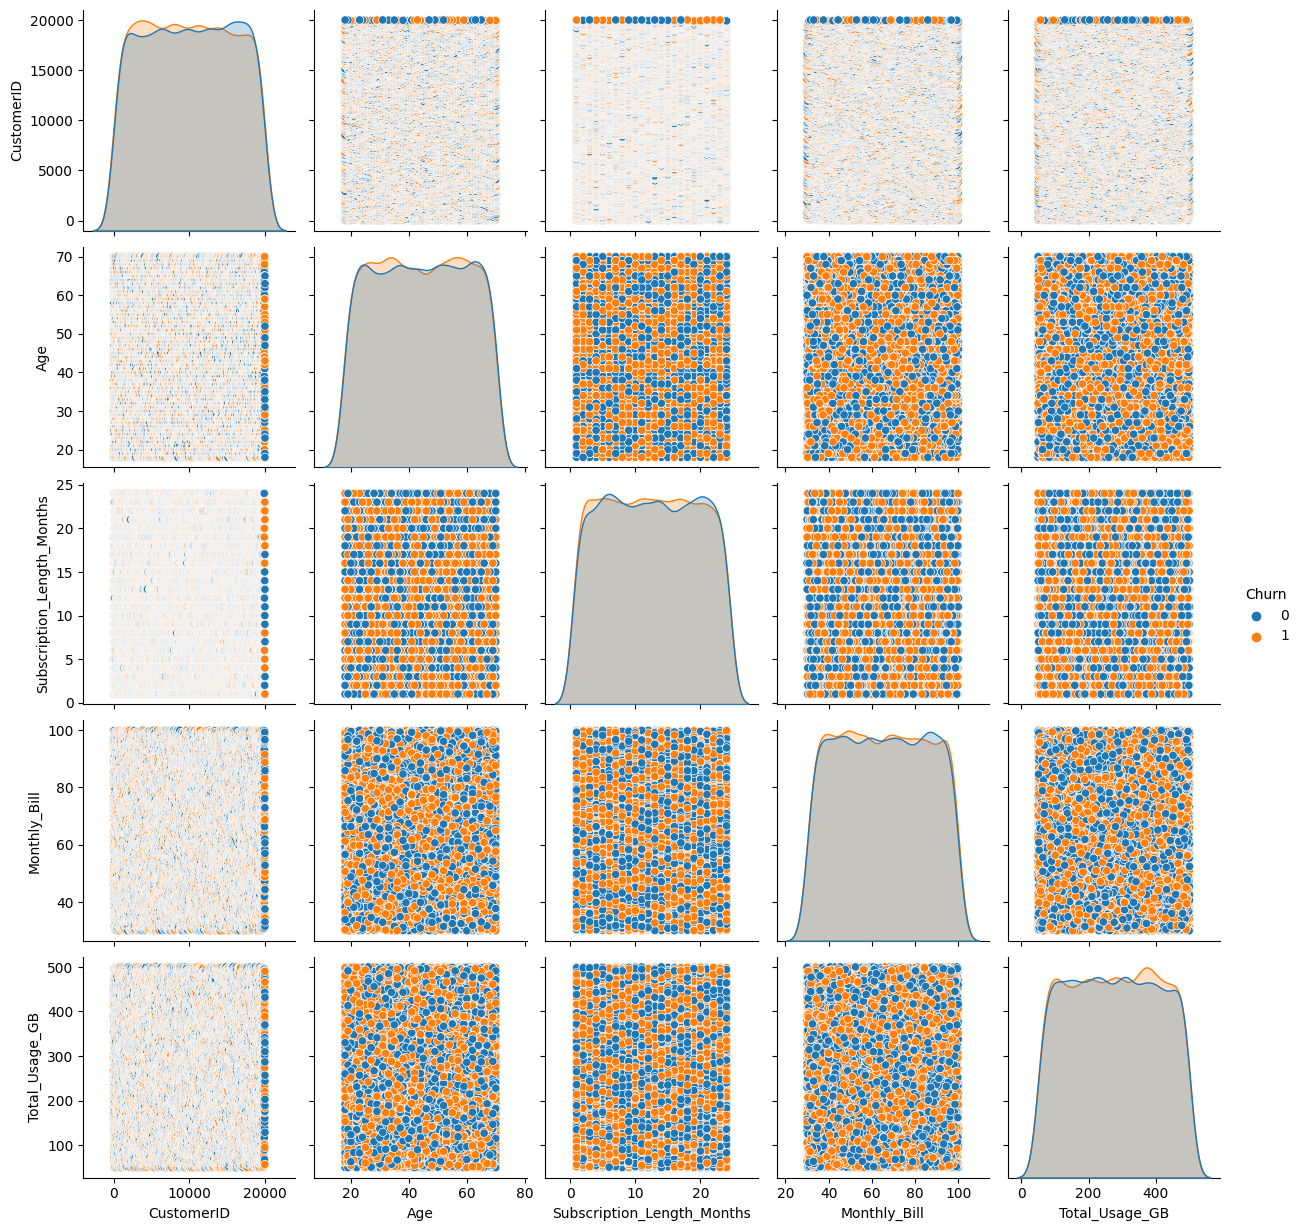

In [ ]:
sns.pairplot(df.iloc[0:20000], hue= 'Churn')

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


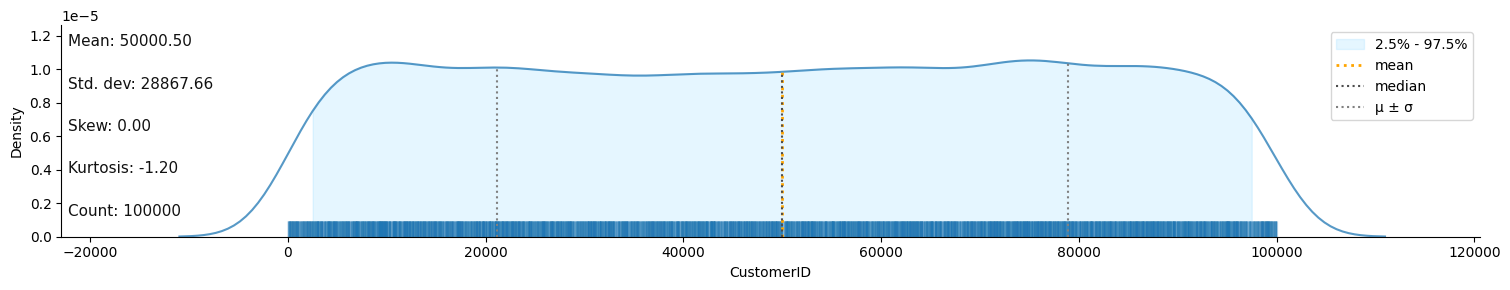

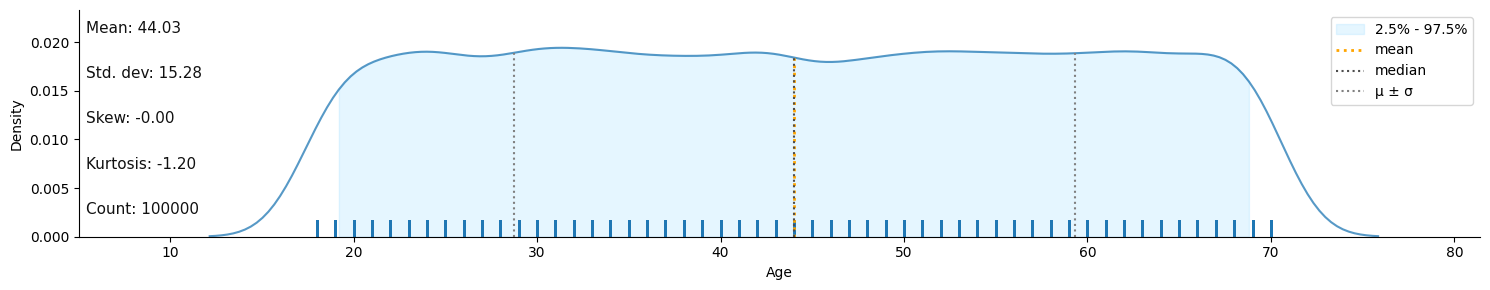

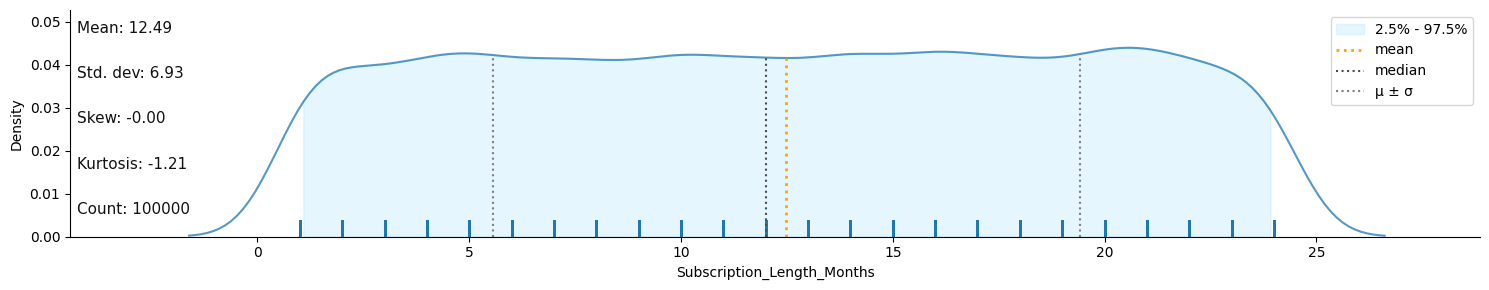

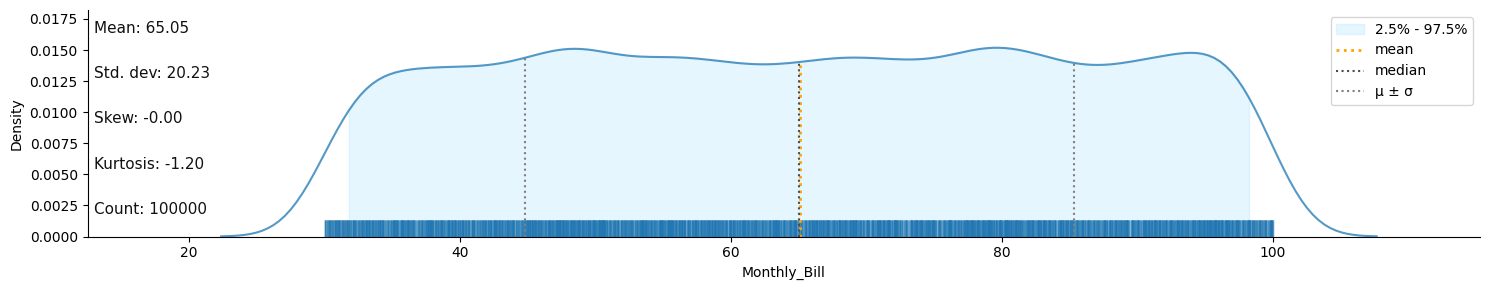

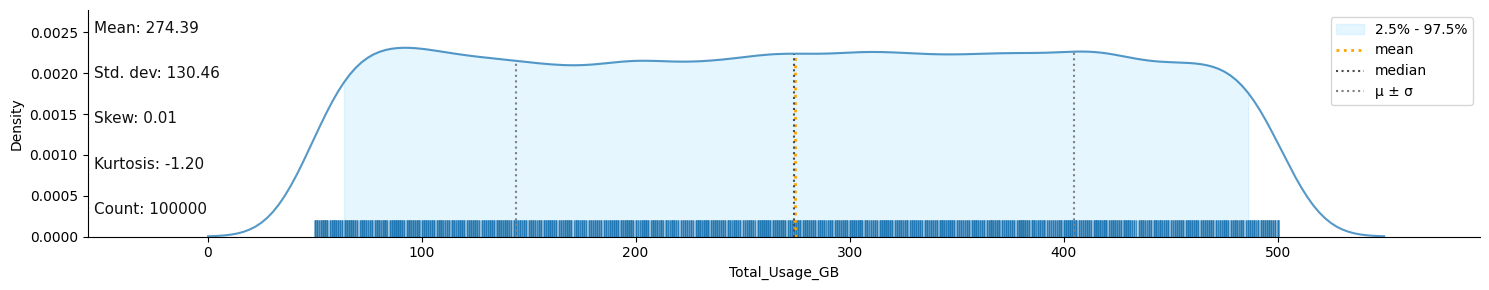

In [ ]:
# Distribution plots for all numerical features
for column in num_columns:
    klib.dist_plot(df[[column]])

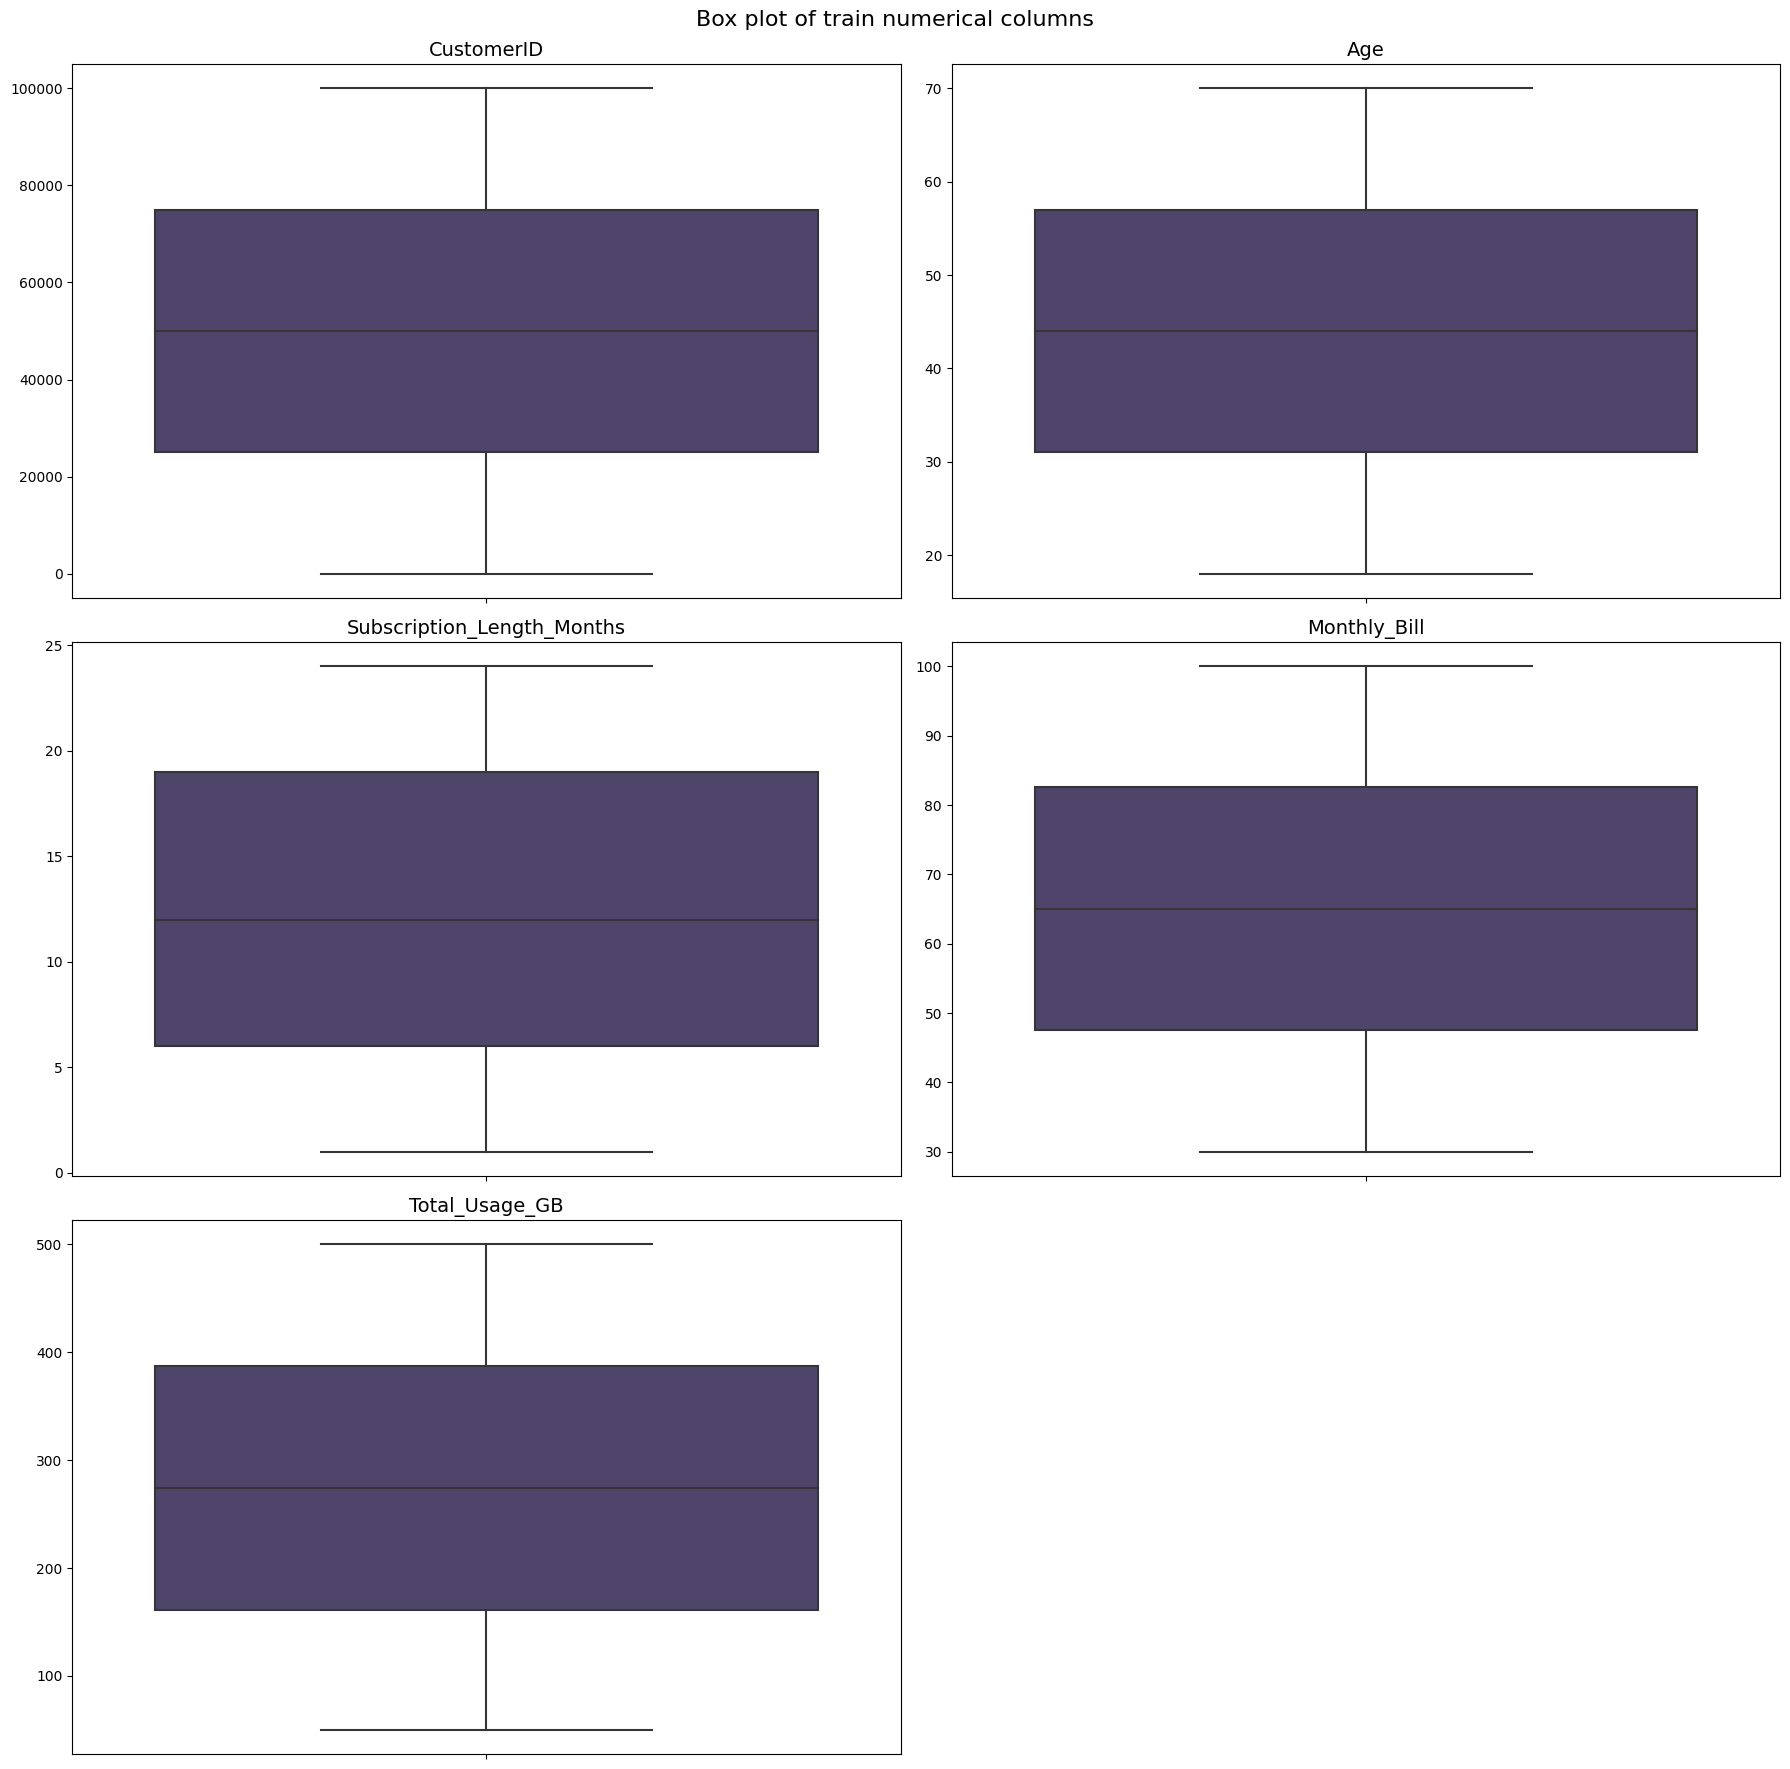

In [ ]:

# Box plot for all numerical features
v0 = sns.color_palette(palette='viridis').as_hex()[0]

fig, axes = plt.subplots(3, 2, figsize=(18,18))  # 3 rows, 2 columns
fig.suptitle('Box plot of train numerical columns', fontsize=16)

for i, col in enumerate(num_columns):
    row = i // 2  # integer division gives us the row number
    col = i % 2   # remainder gives us the column number
    sns.boxplot(data=X[num_columns[i]], color=v0, saturation=.5, ax=axes[row, col])
    axes[row, col].set_title(num_columns[i], fontsize=14)
    axes[row, col].set_xticklabels(labels=[], fontsize=14)  # remove x labels for clarity

# Remove any extra subplots
for i in range(len(num_columns), 6):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

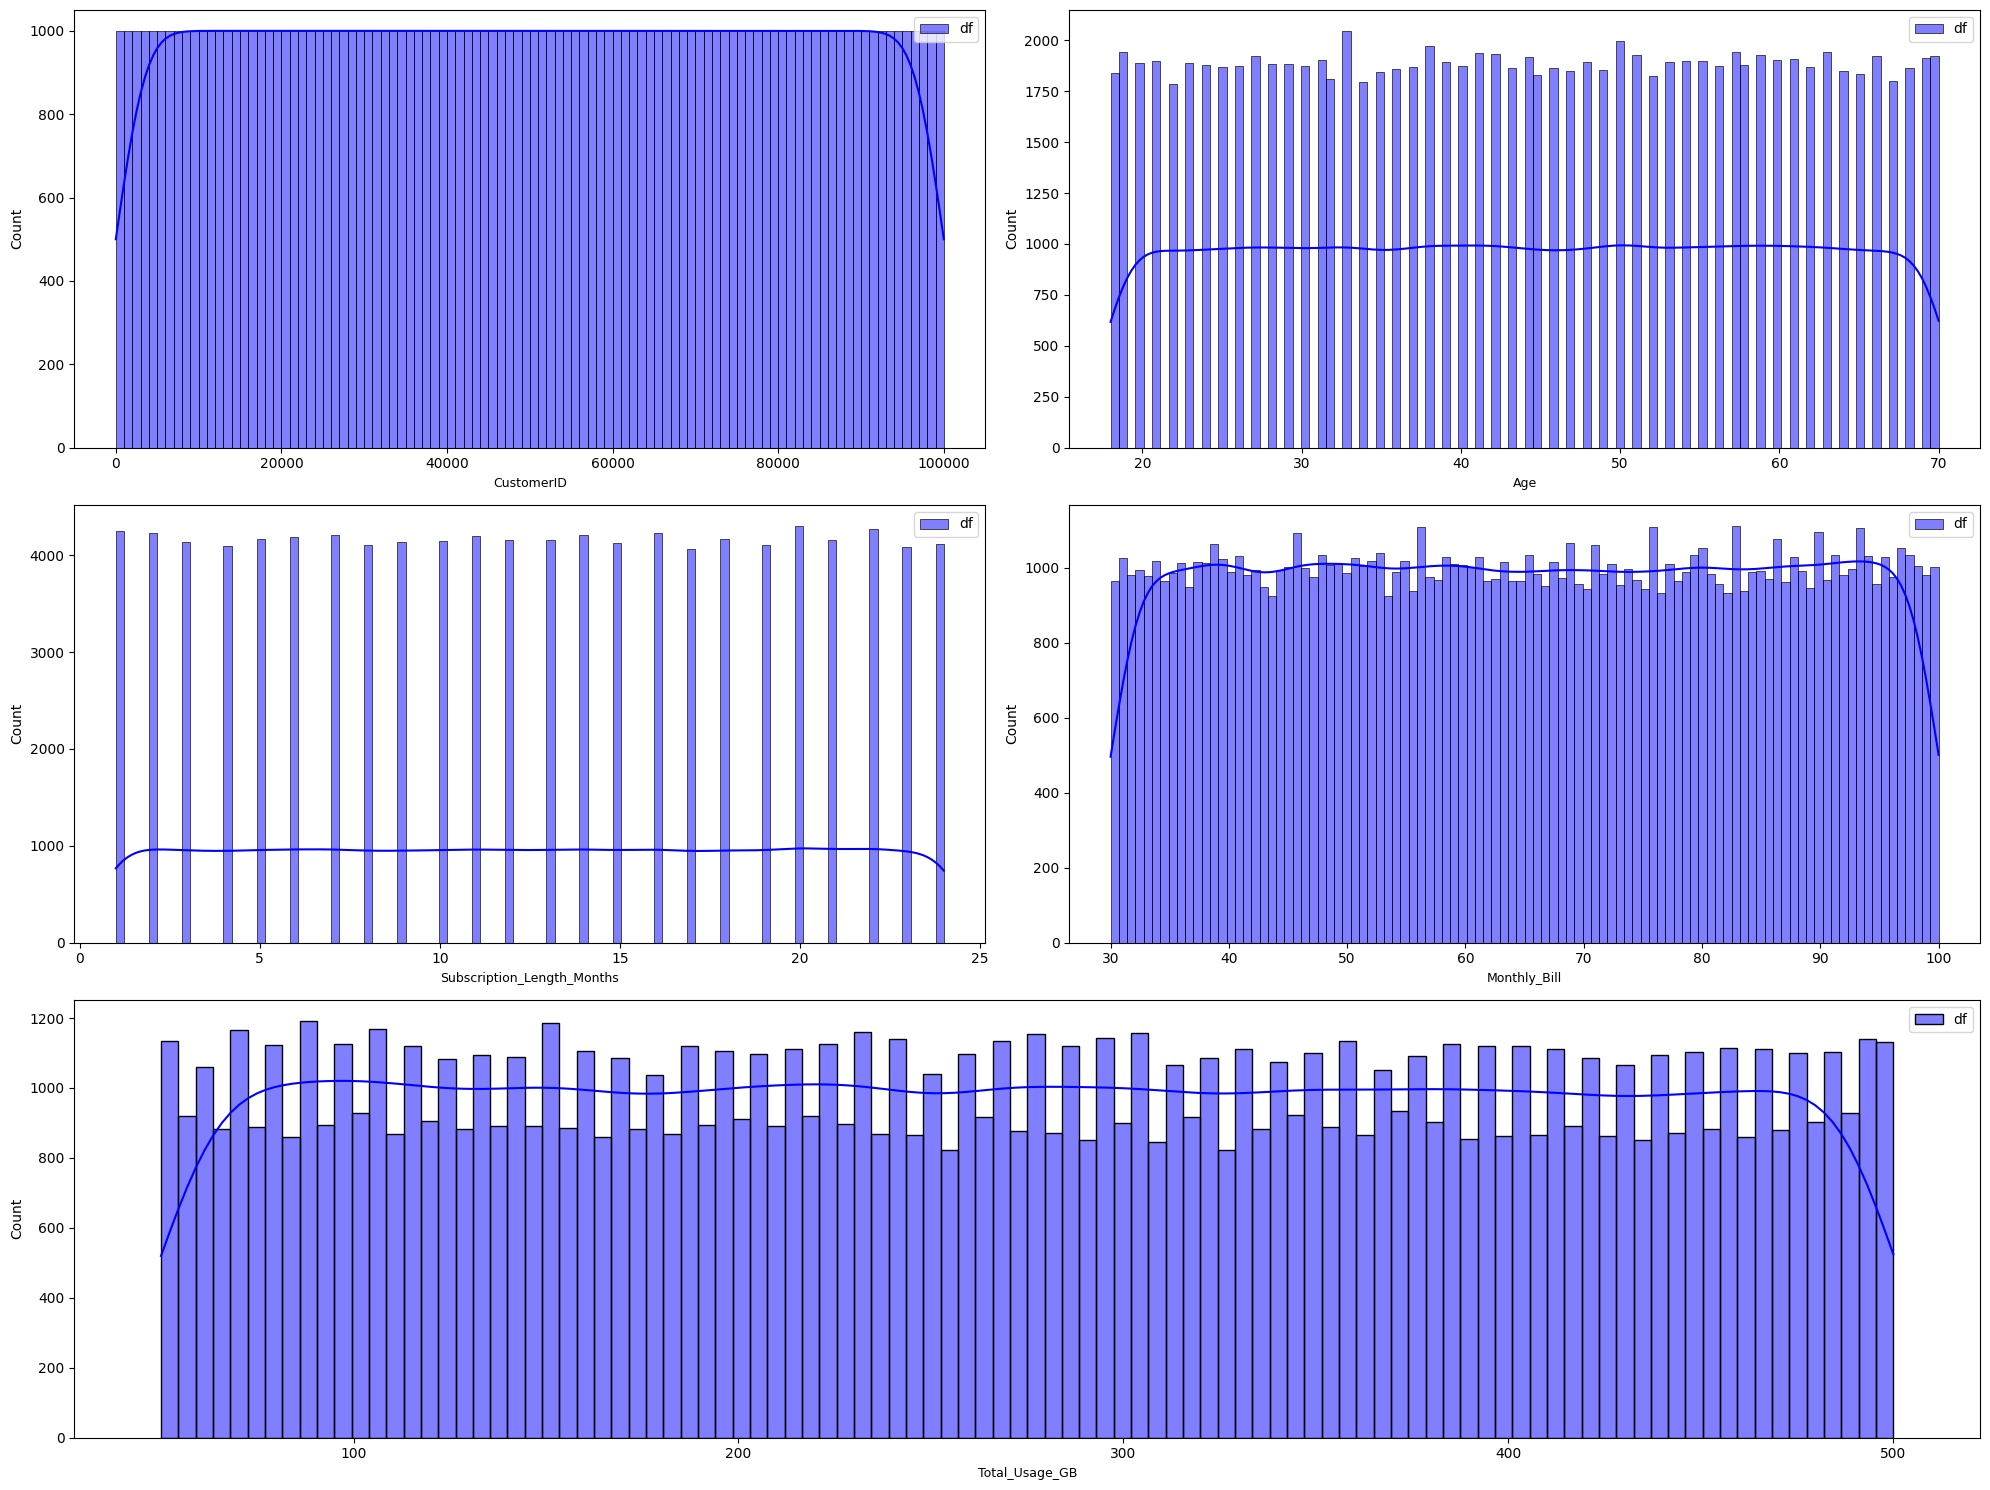

In [ ]:
# Count plot for the numerical features in the dataset

plt.figure(figsize=(20, 15))

for i, feature in enumerate(num_columns, start=1):
    if i == 6:  # Break after plotting 5 graphs
        break

    if i <= 2:  # First two plots
        plt.subplot(3, 2, i)
    elif i <= 4:  # Next two plots
        plt.subplot(3, 2, i)
    else:  # Fifth plot
        plt.subplot(3, 1, 3)

    sns.histplot(df[feature], color="blue", kde=True, bins=100, label='df')
    plt.xlabel(feature, fontsize=9)
    plt.legend()

plt.tight_layout()
plt.show()


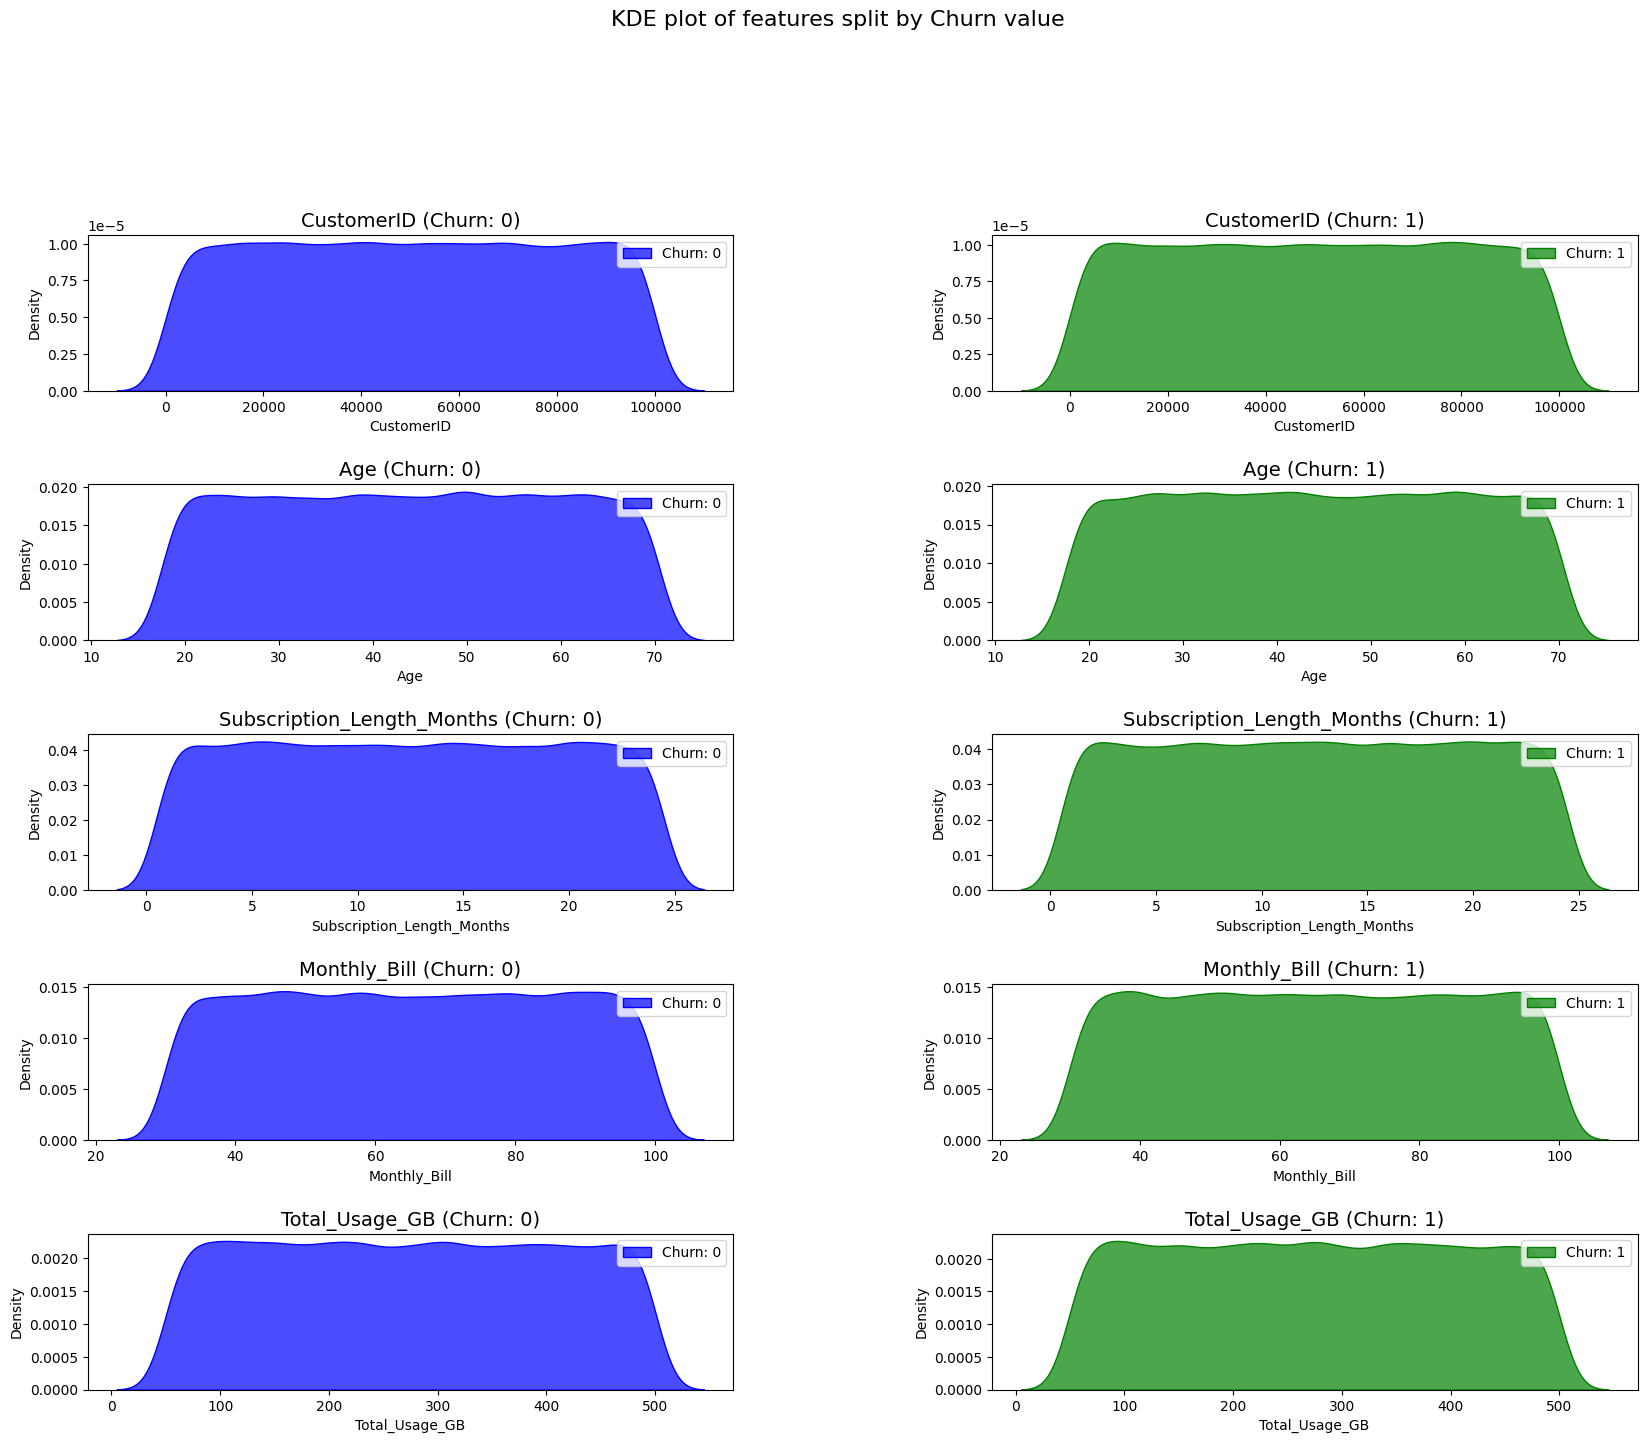

In [ ]:
# KDE plot of target with numerical features in the dataset
fig = plt.figure(figsize=(20,15))
grid = gridspec.GridSpec(len(num_columns),2,figure=fig,hspace=.6,wspace=.4)

for n, col in enumerate(num_columns):
    # Plotting distribution for Churn = 0
    ax = fig.add_subplot(grid[n, 0])
    sns.kdeplot(data=df[df['Churn'] == 0], x=col, ax=ax, color="blue", label="Churn: 0", alpha=.7,fill=True)
    ax.set_title(f"{col} (Churn: 0)", fontsize=14)
    ax.set_ylabel('Density')
    ax.legend()

    # Plotting distribution for Churn = 1
    ax = fig.add_subplot(grid[n, 1])
    sns.kdeplot(data=df[df['Churn'] == 1], x=col, ax=ax, color="green", label="Churn: 1", alpha=.7,fill=True)
    ax.set_title(f"{col} (Churn: 1)", fontsize=14)
    ax.set_ylabel('Density')
    ax.legend()

fig.suptitle('KDE plot of features split by Churn value', fontsize=16, y=1.03);
plt.show()

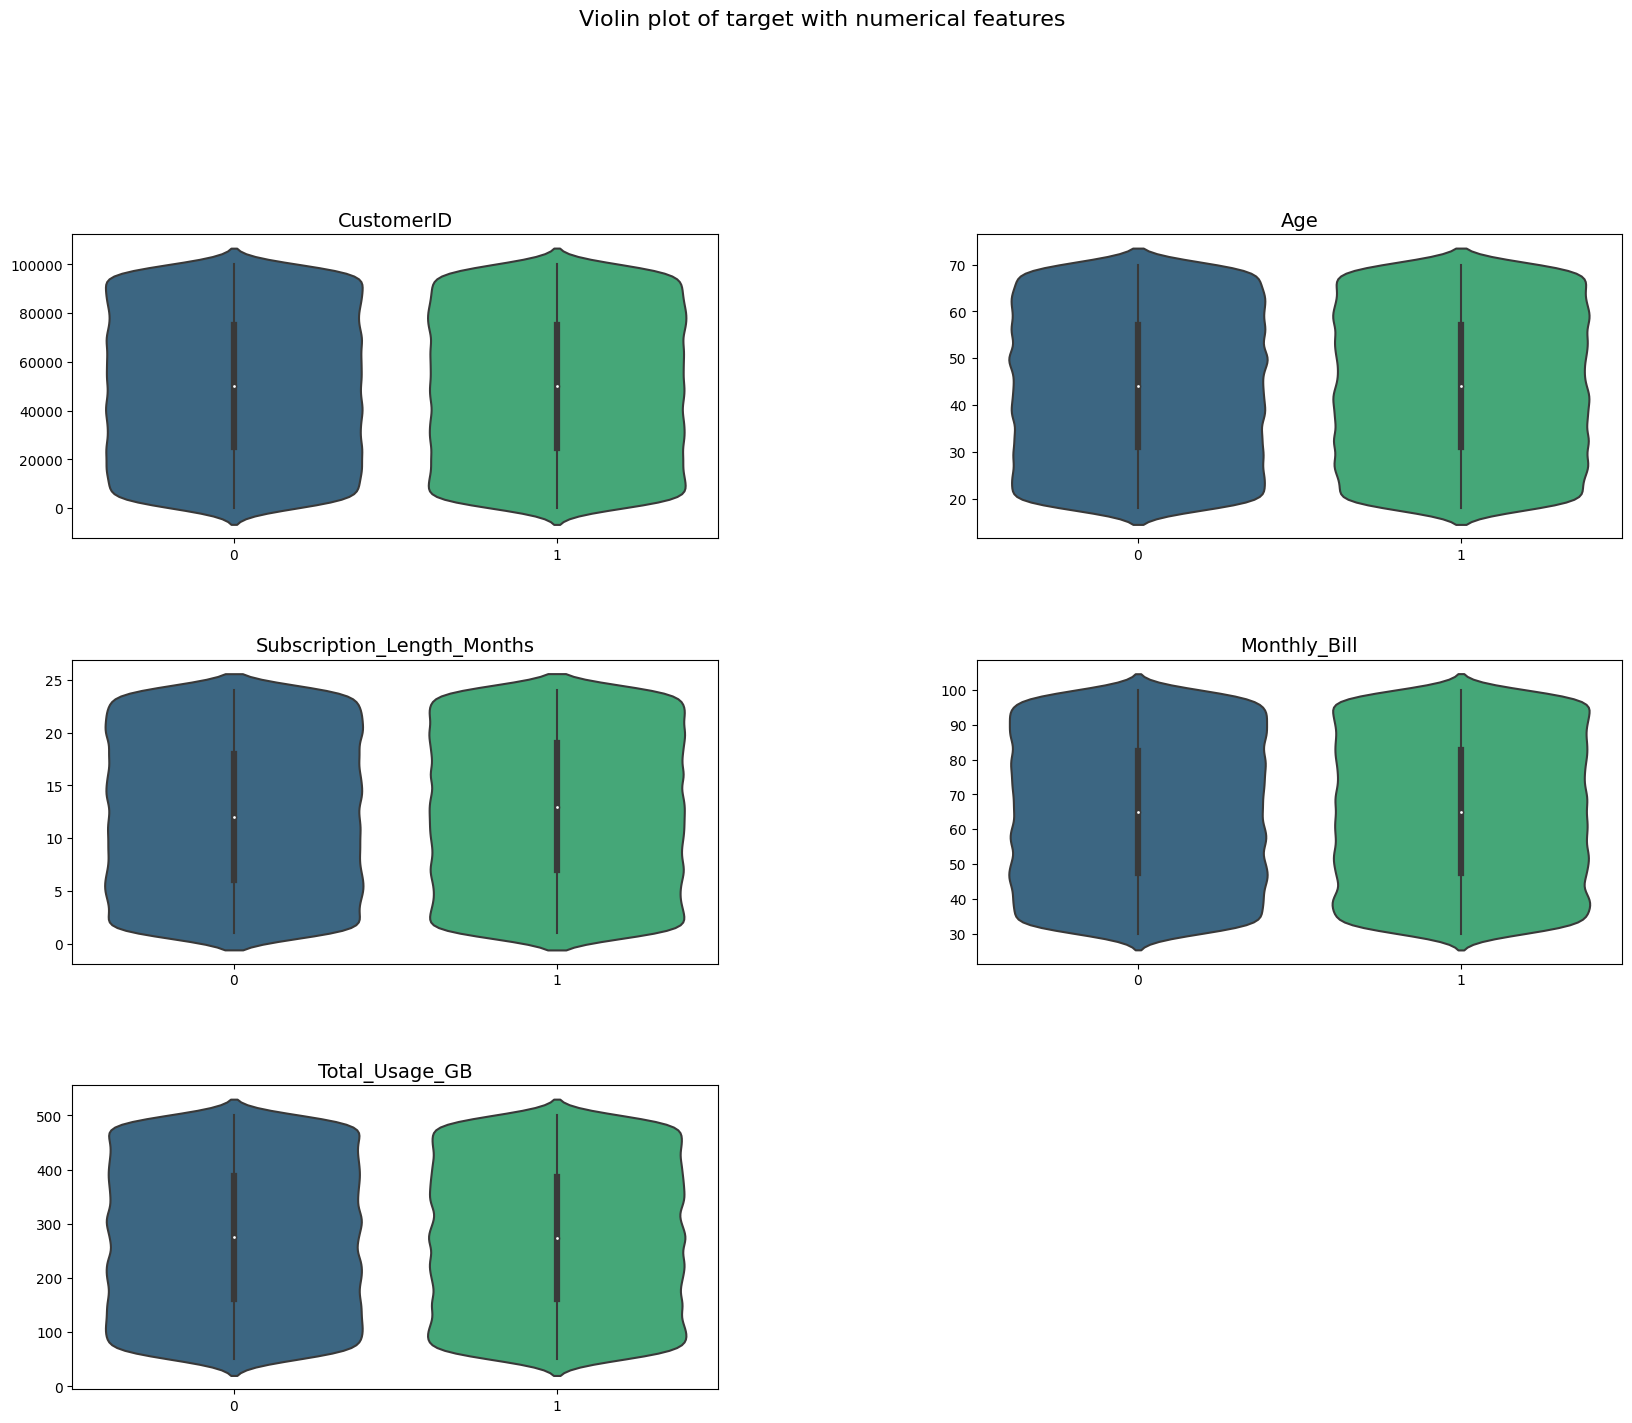

In [ ]:
# Violin plot of target with numerical features in the dataset
fig = plt.figure(figsize=(20,15))
grid = gridspec.GridSpec(3,2,figure=fig,hspace=.4,wspace=.4)

for n, col in enumerate(num_columns):
    ax = fig.add_subplot(grid[n // 2, n % 2])
    sns.violinplot(data=df, y=col, x='Churn', ax=ax, alpha=.7, fill=True, palette='viridis')
    ax.set_title(col, fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Violin plot of target with numerical features', fontsize=16, y=1.03);
plt.show()

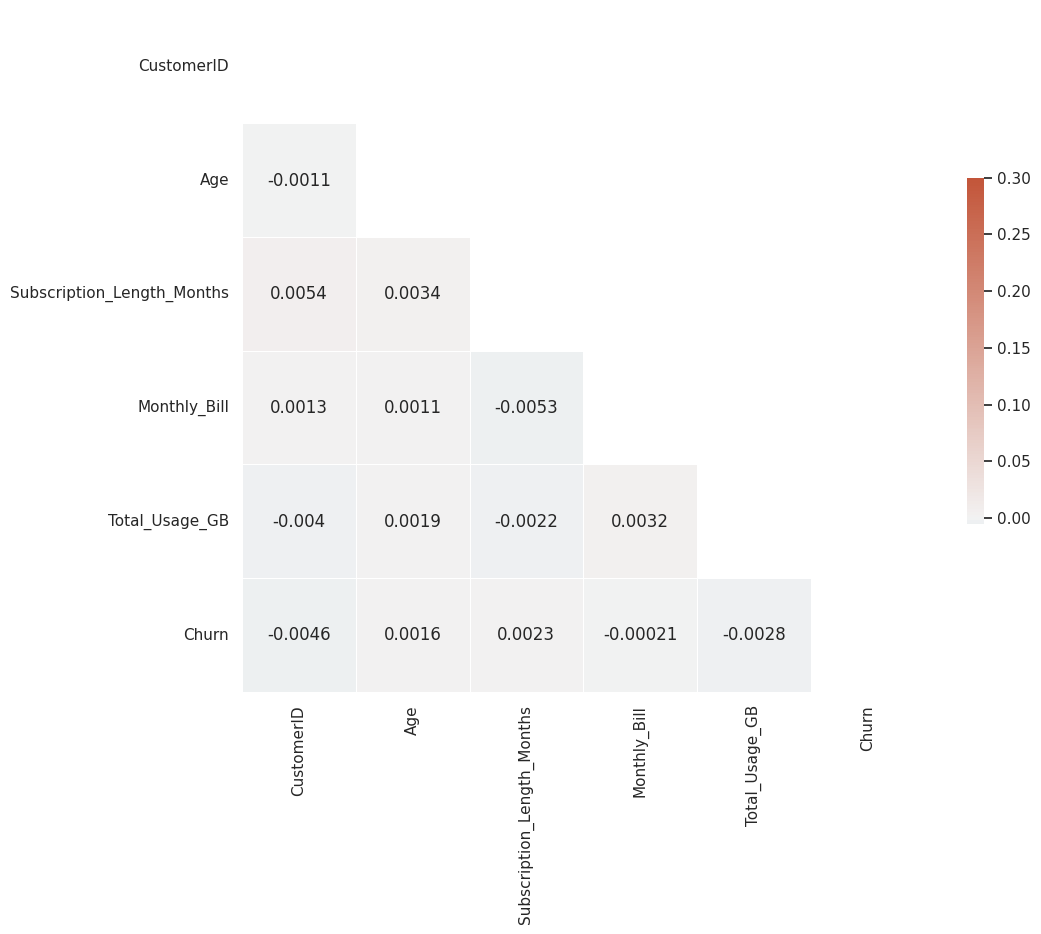

In [ ]:
# Set a theme for seaborn
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

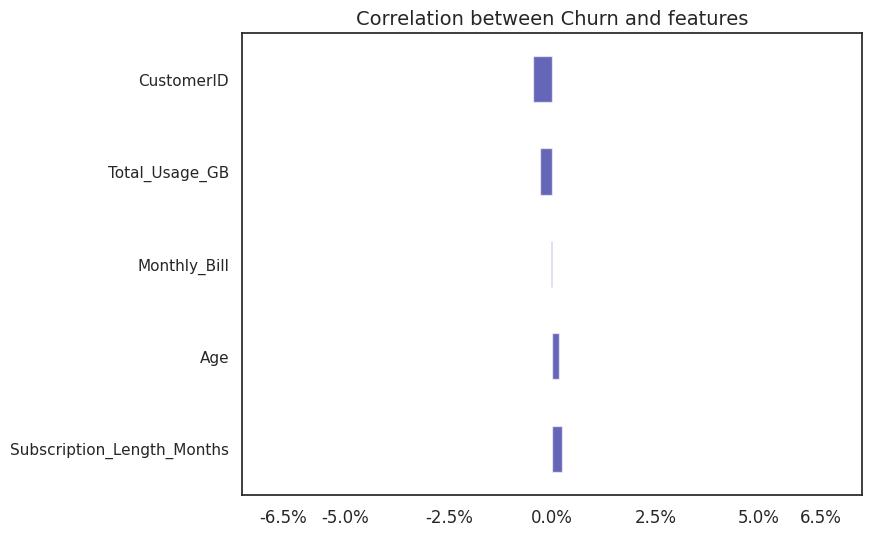

In [ ]:
# Calculate correlation with the target column 'Churn'
correlation_with_target = df.corr()['Churn'].sort_values(ascending=False)
correlation_with_target.drop('Churn', inplace=True)  # remove the Churn-Churn self correlation

correlation_with_target.plot.barh(figsize=(8,6), alpha=0.6, color='darkblue')
plt.xlim(-0.075, 0.075)  # Adjusting limits for smaller correlation values
plt.xticks([-0.065, -0.05 , -0.025,  0.0,  0.025,  0.05,  0.065],
           [str(round(100*i, 2))+'%' for i in [-0.065, -0.05 , -0.025,  0.0,  0.025,  0.05,  0.065]], fontsize=12)
plt.title('Correlation between Churn and features', fontsize=14)
plt.show()

In [ ]:
# Correlation
df.corr().style.background_gradient(cmap='viridis')

,CustomerID,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
CustomerID,1.000000,-0.001085,0.005444,0.001267,-0.004025,-0.004586
Age,-0.001085,1.000000,0.003382,0.001108,0.001927,0.001559
Subscription_Length_Months,0.005444,0.003382,1.000000,-0.005292,-0.002203,0.002328
Monthly_Bill,0.001267,0.001108,-0.005292,1.000000,0.003184,-0.000208
Total_Usage_GB,-0.004025,0.001927,-0.002203,0.003184,1.000000,-0.002842
Churn,-0.004586,0.001559,0.002328,-0.000208,-0.002842,1.000000


In [ ]:
# Total no of Churned and Not Churned values
df.Churn.value_counts()

0    50221
1    49779
Name: Churn, dtype: int64

**Summary:**

From the Above undersanding we observed that the entire data set is balanced with respect to target feature and also each feature is uniformly distributed.
And also all the features are independent with respect to each other.The correlation with the target variable also very less for all the features


##**Data preprocessing**
Data preprocessing comes after you've cleaned up your data and after you've done some exploratory analysis to understand your dataset. Once you understand your dataset, you'll probably have some idea about how you want to model your data. Machine learning models in Python require numerical input, so if your dataset has categorical variables, you'll need to transform them. Think of data preprocessing as a prerequisite for modeling.

In [ ]:
# Dropping the unrelated columns from the dataset
X.drop(['CustomerID','Name'],axis=1,inplace=True)

**Feature Elimination:**

When it comes to using **customer_id** and **customer_name** for predictions, here are some considerations:

**Irrelevant for Model:**
In most cases, customer-specific identifiers like customer_id and customer_name don't contain any predictive power. For a binary classification task, unless the IDs or names themselves have some specific relevance to the outcome (which is highly unlikely), they won't be useful as predictors.

**Risk of Overfitting:** Including such unique identifiers can sometimes lead to overfitting. The model might "memorize" specific IDs in relation to outcomes in the training set, but this won't generalize well to unseen data.

**Data Leakage:** If there's any pattern in which IDs were assigned (e.g., customers who joined earlier have lower IDs), and the outcome variable is in some way related to this pattern (e.g., older customers are more likely to churn), then including customer_id could introduce data leakage.

**Space and Computational Efficiency:** Removing irrelevant columns helps in reducing the dimensionality, which in turn can lead to faster training times and can help models perform better.

**Interpretability:** Models become more interpretable when they are built on relevant features. Including identifiers may create noise and reduce the clarity of understanding which features are driving predictions.

###**Data Split:**

In [ ]:
# Split the dataset and labels into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0,stratify=y )
print("{} rows in test set vs. {} in training set. {} Features.".format(X_test.shape[0], X_train.shape[0], X_test.shape[1]))

20000 rows in test set vs. 80000 in training set. 8 Features.


In [ ]:
# Columns to be one-hot encoded
categorical_features = ['Gender', 'Location']

# Columns to be standardized (scaled)
numeric_features = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

**Feature Scaling:**

When the data is uniformly distributed, the choice of scaling technique for numerical variables often depends on the specific algorithms you intend to use, rather than the distribution of the data. However, there are some considerations to keep in mind:

**Min-Max Scaling:** Rescales data to a [0, 1] range. It retains the distribution's uniform nature, but outliers can distort this scale.

**StandardScaler:** Centers data around zero, scaling by standard deviation. Uniform distribution remains intact, but it's also outlier-sensitive.

**RobustScaler:** Primarily for outlier-heavy datasets; uniformly distributed data sees limited benefits.

**Log Transformation and Box-Cox:** Better suited for skewed datasets.

**So, what's the best approach?**
* For distance-sensitive algorithms like K-NN or SVM,
both Min-Max and StandardScaler are viable. The preference hinges on whether a [0,1] range or a zero-centered scale is desired.

* For magnitude-focused algorithms (like certain linear regressions), any uniform scaling method will suffice.
* Tree-based models, like decision trees or random forests, aren't typically scale-dependent, making scaling optional.


**Feature Encoding:**

**Label/Ordinal Encoding:**  Gender, typically having two categories like Male and Female, can easily be label-encoded. This means assigning '0' to one category and '1' to the other. It's straightforward and efficient.
**One-Hot Encoding:** Another approach is one-hot encoding. This would lead to two columns, for instance, is_male and is_female. But since knowing one gives away the other, one column is typically enough. While decision trees and forests handle this redundancy well, for linear models, it's better to remove the redundant column to prevent multicollinearity.

**Decision for Gender:** Given the binary nature of gender, label/ordinal encoding is a preferred and simpler choice.

**Location (5 Categories):**

**Ordinal/Label Encoding:** If locations have a clear hierarchical structure, ordinal encoding makes sense. However, without a defined order, label encoding could be misleading. It assumes an arbitrary order, which can be misinterpreted by models, especially linear ones.

**One-Hot Encoding:** For categorical features with a limited set of values, like our Location with 5 categories, one-hot encoding is often recommended. This method would convert Location into five binary columns, each representing a location category.

**Decision for Location:** Without a defined order for the locations, one-hot encoding stands out as the logical choice. This method ensures that our models don't make unfounded ordinal assumptions about the data.



###**Model Selection:**




**K-Nearest Neighbors (KNN)**

Overview: KNN is a non-parametric, instance-based learning algorithm. It classifies a sample based on how its neighbors are classified. The algorithm doesn't make any assumptions about the underlying data distribution, making it particularly useful for problems where the decision boundary is very irregular.

**Strengths:**

Simple and easy to understand.
Performs well with a small number of input variables (low dimensionality).
No training phase (lazy learner).

**Support Vector Machine (SVC)**

Overview: SVC is a powerful, linear model that uses a technique called the "kernel trick" to transform your data and then, based on these transformations, finds an optimal boundary between the possible outputs.

**Strengths:**

Effective in high dimensional spaces.
Uses only a subset of training points in the decision function (support vectors), making it memory efficient.
Versatile: can specify different kernel functions for the decision function.


**Random Forest**

Overview: Random Forest is an ensemble of decision trees, typically trained with the "bagging" method. The idea behind bagging is to combine the results of multiple models (in this case, decision trees) to get a generalized result.

**Strengths:**

Can handle binary features, categorical features, and numerical features without any need for scaling.
Can handle missing values.
Can model the non-linear decision boundary.


**Note:**
* Due to the non availability of resource constraints we are using random sampling technique to train the model.
* To select the best model we are using this method.
* After finding the best model we will use entire dataset.  

###**Preprocessing pipeline:**

In [ ]:
# Preprocessing for numeric data
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

# Preprocessing for categorical data
categorical_transformers = [
    ('ordinal_enc', OrdinalEncoder(), ['Gender']),
    ('location', OneHotEncoder(), ['Location'])
]

# Bundle preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', ColumnTransformer(categorical_transformers, remainder='passthrough'), categorical_features)
    ])

###**Random Forest model:**

In [ ]:
# Define the pipeline
rnn_model = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', RandomForestClassifier())])

# Parameters for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': np.arange(50, 301, 50),
    'classifier__max_depth': [None] + list(np.arange(5, 31, 5)),
    'classifier__min_samples_split': np.arange(2, 21, 2),
    'classifier__min_samples_leaf': np.arange(1, 21, 2),
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy']
}

# Random sampling of the dataset for faster training
sample_X_train, _, sample_y_train, _ = train_test_split(X_train, y_train, test_size=0.75, stratify=y_train, random_state=42)

# Perform RandomizedSearchCV
search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
search.fit(sample_X_train, sample_y_train)

# Predict and evaluate on the test set
y_pred = search.predict(X_test)

print("Best parameters:", search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 3, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
Accuracy: 0.5016
Confusion Matrix:
[[5722 4322]
 [5646 4310]]


###**KNN model:**

In [ ]:
# Define the pipeline for KNN
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier())])

# Parameters for RandomizedSearchCV for KNN
knn_param_dist = {
    'classifier__n_neighbors': np.arange(1, 51, 2),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'classifier__p': [1, 2]  # 1: Manhattan Distance, 2: Euclidean Distance
}

# Random sampling of the dataset for faster training
sample_X_train, _, sample_y_train, _ = train_test_split(X_train, y_train, test_size=0.75, stratify=y_train, random_state=42)

# Perform RandomizedSearchCV for KNN
knn_search = RandomizedSearchCV(knn_model, param_distributions=knn_param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
knn_search.fit(sample_X_train, sample_y_train)

# Predict and evaluate on the test set for KNN
knn_y_pred = knn_search.predict(X_test)

print("Best parameters for KNN:", knn_search.best_params_)
print("Accuracy for KNN:", accuracy_score(y_test, knn_y_pred))
print("Confusion Matrix for KNN:")
print(confusion_matrix(y_test, knn_y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters for KNN: {'classifier__weights': 'distance', 'classifier__p': 2, 'classifier__n_neighbors': 1, 'classifier__algorithm': 'brute'}
Accuracy for KNN: 0.50445
Confusion Matrix for KNN:
[[5147 4897]
 [5014 4942]]


###**SVC model:**

In [ ]:
# Define the pipeline for Support Vector Classifier
svc_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(probability=True))])  # Setting probability=True to allow for predict_proba in case you need it later
svc_param_dist = {
    'classifier__C': np.logspace(-3, 3, 7),  # Regularization parameter. The strength of the regularization is inversely proportional to C.
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Specifies the kernel type to be used in the algorithm.
    'classifier__gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
    'classifier__degree': [2, 3, 4, 5]  # Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
}
# Random sampling of the dataset for faster training
sample_X_train, _, sample_y_train, _ = train_test_split(X_train, y_train, test_size=0.75, stratify=y_train, random_state=42)

svc_search = RandomizedSearchCV(svc_model, param_distributions=svc_param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
svc_search.fit(sample_X_train, sample_y_train)

svc_y_pred = svc_search.predict(X_test)

print("Best parameters for SVC:", svc_search.best_params_)
print("Accuracy for SVC:", accuracy_score(y_test, svc_y_pred))
print("Confusion Matrix for SVC:")
print(confusion_matrix(y_test, svc_y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


###**Best Model:**

from the above Results We can conclude that all the results are nearly same .So we can consider any of the model, but due to the **many strenghts and the robust nature** of **Random forest** algorithm We are choosing the **Random forest** as the **best model**.

###**Pipeline Creation:**

In [ ]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

###**Model Fitting and Tuning:**

In [ ]:
# Parameters for RandomForest
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring='accuracy')

# Fit the models
grid_search_rf.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Subscription_Length_Months',
                                                                          'Monthly_Bill',
                                                                          'Total_Usage_GB']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Gender',
                                                                          'Location'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='accuracy')

###**Prediction And Results:**

Accuracy: 0.4966


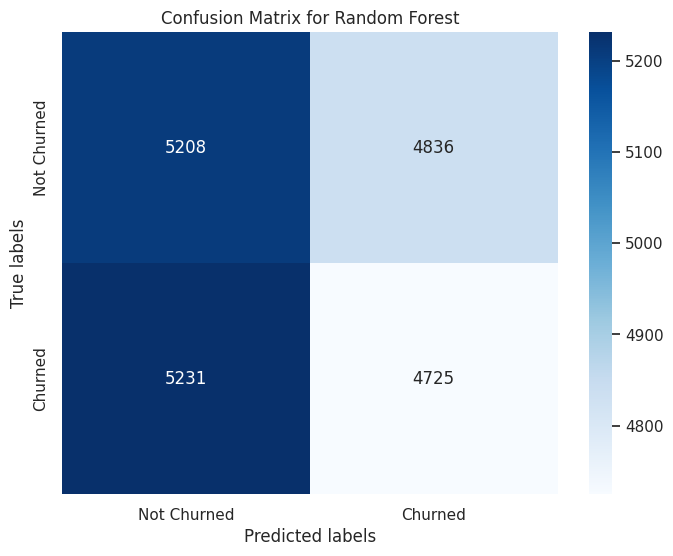

In [ ]:
# Predictions
rf_preds = grid_search_rf.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test, rf_preds)
print(f"Accuracy: {rf_acc:.4f}")

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_preds)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(rf_cm, annot=True, fmt='g', cmap="Blues",
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

###**Save And Load the model:**

In [ ]:
# Save
dump(grid_search_rf, '/content/drive/My Drive/trained_model.joblib')

# Load
loaded_model = load('/content/drive/My Drive/trained_model.joblib')

###**Prediciton Using Pretrained model:**

In [ ]:

def predict_churn(data):
    prediction = loaded_model.predict(data)
    return "Churned" if prediction[0] == 1 else "Not Churned"

# Create a DataFrame
data = pd.DataFrame([[51, 'Male', 'Miami', 27, 52.0521, 152]], columns=['Age', 'Gender', 'Location', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB'])

# Use the function to get a human-readable prediction
print(predict_churn(data))

Not Churned


###**Model Deployment:**

In [ ]:
!python /content/drive/My Drive/Sunbase/app_flask.py
